In [1]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pickle
import joblib
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize

In [2]:
path_csv = "./ESC-50-master/meta/esc50.csv"

In [3]:
df = pd.read_csv(path_csv)

In [4]:
df

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [5]:
category = ["crying_baby", "sneezing", "clapping", "breathing", "coughing", "footsteps", "laughing", "brushing_teeth", "snoring", "drinking_sipping"]

In [6]:
df = df.loc[df["category"].isin(category)]

In [7]:
df = df.reset_index(drop=True)

In [8]:
sample_num = 1
sr = 44100
max_size = 480
hop_length = 512
n_fft = 255
h = 128
n_mfcc = 128
epoch = 30
n_batch = 10

In [9]:
s = df.loc[sample_num,['filename']].values[0]
filename= f"./ESC-50-master/audio/{s}"
print(filename)

./ESC-50-master/audio/1-104089-B-22.wav


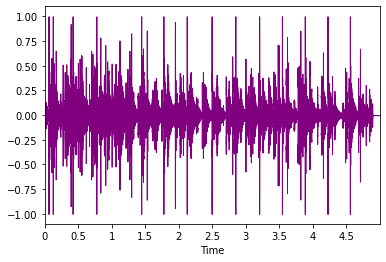

In [10]:
y, sr = librosa.load(filename, sr=sr)
librosa.display.waveplot(y, sr=sr, x_axis='time', color='purple',offset=0.0)

In [11]:
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [12]:
def generate_features(y_cut):
    stft = padding(np.abs(librosa.stft(y_cut, n_fft=n_fft, hop_length = hop_length)), h, max_size)
    MFCCs = padding(librosa.feature.mfcc(y_cut, n_fft=n_fft, hop_length = hop_length,n_mfcc=n_mfcc),h,max_size)
    spec_centroid = librosa.feature.spectral_centroid(y=y_cut, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr)
    #Now the padding part
    image = np.array([padding(normalize(spec_bw),1, max_size)]).reshape(1,max_size)
    image = np.append(image,padding(normalize(spec_centroid),1, max_size), axis=0) 
    #repeat the padded spec_bw,spec_centroid and chroma stft until they are stft and MFCC-sized
    for i in range(0,9):
        image = np.append(image, padding(normalize(spec_bw),1, max_size), axis=0)
        image = np.append(image, padding(normalize(spec_centroid),1, max_size), axis=0)
        image = np.append(image, padding(normalize(chroma_stft),12, max_size), axis=0)
    image=np.dstack((image,np.abs(stft)))
    image=np.dstack((image,MFCCs))
    return image

In [13]:
result = generate_features(y)

In [14]:
result.shape

(128, 480, 3)

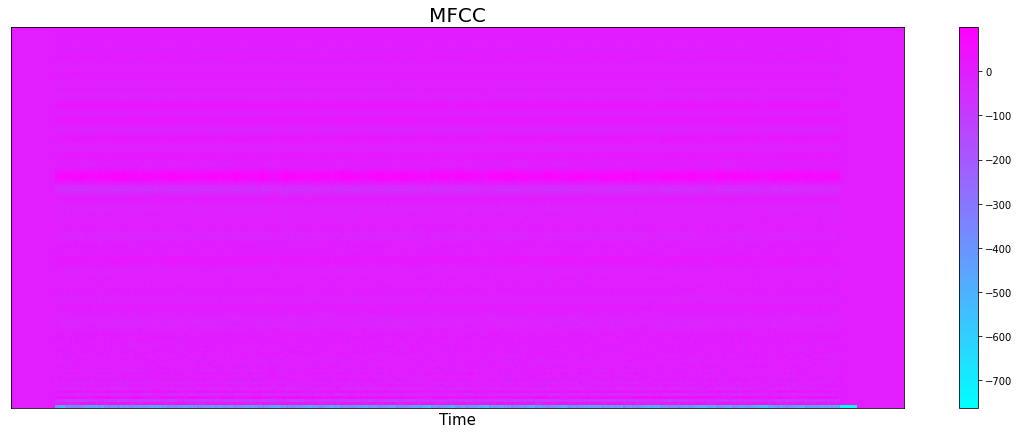

In [15]:
MFCCs = padding(librosa.feature.mfcc(y, n_fft=n_fft, hop_length=hop_length,n_mfcc=n_mfcc),h,max_size)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(MFCCs,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

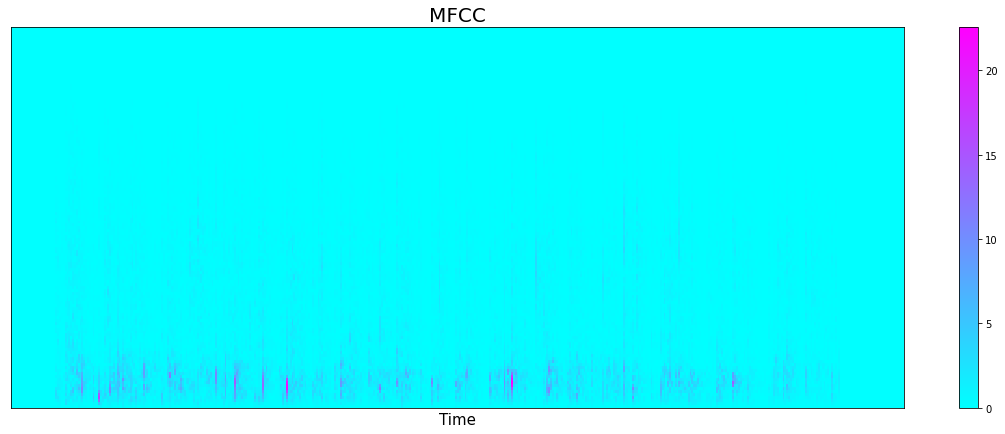

In [16]:
stft = padding(np.abs(librosa.stft(y, n_fft=n_fft, hop_length = hop_length)), h,max_size)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(stft,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

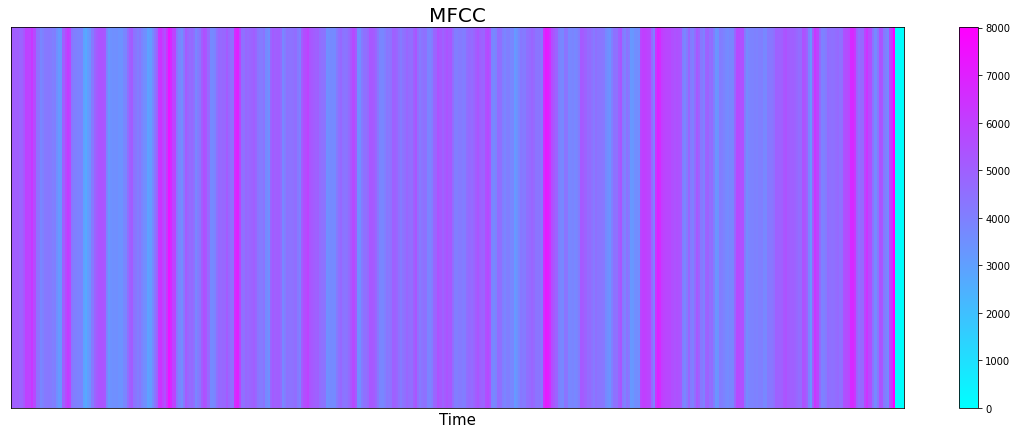

In [17]:
spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(spec_centroid,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

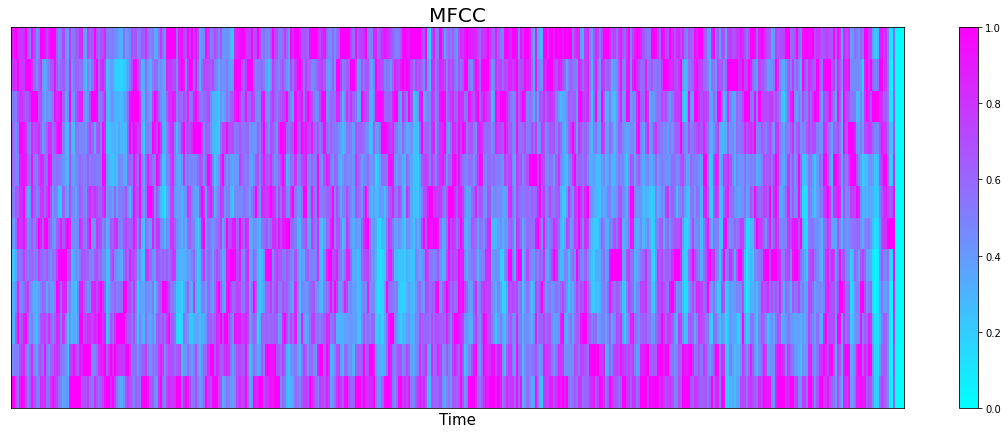

In [18]:
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(chroma_stft,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

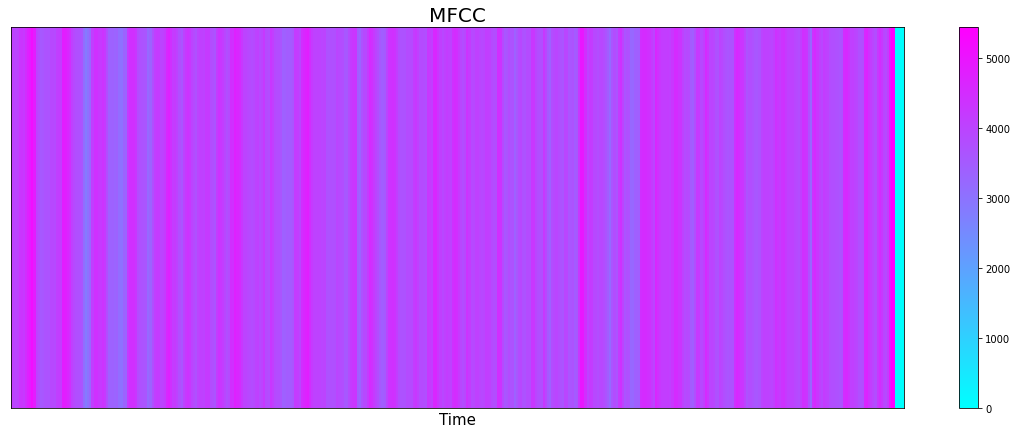

In [19]:
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(spec_bw,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

In [20]:
def get_features(df_in, rs=None):   
    features=[]
    labels = []
    
    for index, row in df_in.iterrows():
        label = df.loc[index,['category']].values[0]
        s = df.loc[index,['filename']].values[0]
        filename = f"./ESC-50-master/audio/{s}" 
        y, sr = librosa.load(filename,sr=44100)
        data = generate_features(y)
        if not rs is None:
            data = resize(data, rs)
        features.append(data[np.newaxis,...])    
        labels.append(label)     
    output=np.concatenate(features,axis=0)     
    return(np.array(output), labels)

In [21]:
X, y = get_features(df, rs=(224,224))

In [22]:
enc = LabelEncoder()
enc.fit(y)
y = enc.transform(y)
n_classes = len(enc.classes_)

In [23]:
X.shape

(400, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


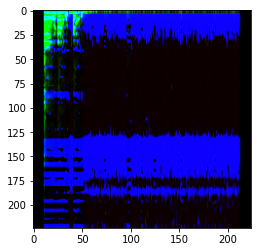

In [24]:
plt.imshow(X[144])

In [25]:
#Split twice to get the validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123)
#Print the shapes
X_train.shape, X_test.shape, X_val.shape, len(y_train), len(y_test), len(y_val)

((225, 224, 224, 3), (100, 224, 224, 3), (75, 224, 224, 3), 225, 100, 75)

In [26]:
X_train = np.array((X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train)))
X_test = np.array((X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test)))
X_val = np.array((X_val-np.min(X_val))/(np.max(X_val)-np.min(X_val)))
X_train = X_train/np.std(X_train)
X_test = X_test/np.std(X_test)
X_val = X_val/np.std(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

# MODEL

In [28]:
#from tensorflow.keras.applications import VGG19
#from tensorflow.keras.applications import Xception
#from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import InceptionV3
#from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

# Intento 1

In [29]:
baseModel = InceptionV3(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/InceptionV3/base-adam-InceptionV3-0.1.h5")

87916544/87910968 [==============================] - 8s 0us/step


In [30]:
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [31]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 14s 247ms/step - loss: 75.8930 - accuracy: 0.1193 - val_loss: 2474851930843068274229379072.0000 - val_accuracy: 0.0667
Epoch 2/30
23/23 [==============================] - 3s 110ms/step - loss: 11.3359 - accuracy: 0.1230 - val_loss: 16692336932151099392.0000 - val_accuracy: 0.1200
Epoch 3/30
23/23 [==============================] - 2s 109ms/step - loss: 17.5529 - accuracy: 0.1084 - val_loss: 55745877901312.0000 - val_accuracy: 0.0667
Epoch 4/30
23/23 [==============================] - 3s 109ms/step - loss: 6.3322 - accuracy: 0.1072 - val_loss: 914340577280.0000 - val_accuracy: 0.1467
Epoch 5/30
23/23 [==============================] - 3s 110ms/step - loss: 5.2945 - accuracy: 0.0618 - val_loss: 13106289664.0000 - val_accuracy: 0.0667
Epoch 6/30
23/23 [==============================] - 3s 110ms/step - loss: 4.0731 - accuracy: 0.1489 - val_loss: 1076405248.0000 - val_accuracy: 0.0667
Epoch 7/30
23/23 [==============================] - 2s 

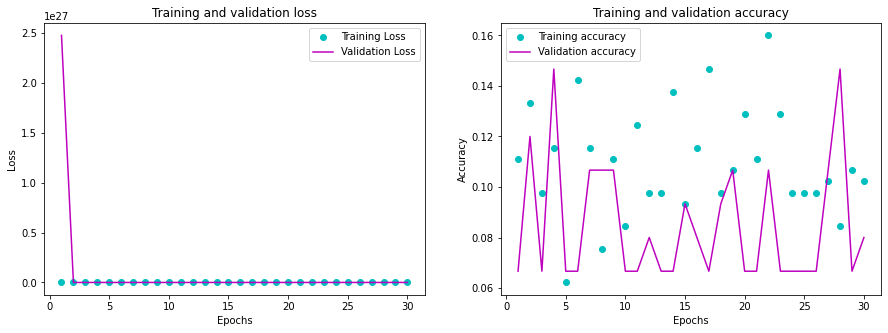

In [32]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [33]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 1s 311ms/step - loss: 2.3295 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0 10  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [34]:
model.save("model/InceptionV3/fit-adam-InceptionV3-0.1.h5")

# Intento 2 

In [35]:
baseModel = InceptionV3(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/InceptionV3/base-adam-InceptionV3-0.01.h5")

In [36]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [37]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 153ms/step - loss: 9.1195 - accuracy: 0.0865 - val_loss: 303096406677940862976.0000 - val_accuracy: 0.1200
Epoch 2/30
23/23 [==============================] - 3s 111ms/step - loss: 3.0731 - accuracy: 0.1180 - val_loss: 50224340926464.0000 - val_accuracy: 0.0667
Epoch 3/30
23/23 [==============================] - 3s 112ms/step - loss: 2.5326 - accuracy: 0.1662 - val_loss: 14112422912.0000 - val_accuracy: 0.1067
Epoch 4/30
23/23 [==============================] - 2s 109ms/step - loss: 2.3812 - accuracy: 0.1266 - val_loss: 9924097.0000 - val_accuracy: 0.1067
Epoch 5/30
23/23 [==============================] - 3s 112ms/step - loss: 2.4509 - accuracy: 0.1039 - val_loss: 258338.7500 - val_accuracy: 0.1200
Epoch 6/30
23/23 [==============================] - 3s 112ms/step - loss: 2.3627 - accuracy: 0.0917 - val_loss: 146714.7031 - val_accuracy: 0.1067
Epoch 7/30
23/23 [==============================] - 2s 108ms/step - loss: 2.3264 - accura

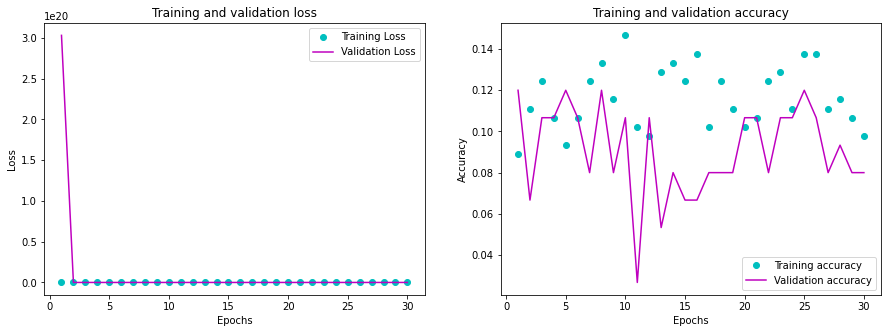

In [38]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [39]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 52ms/step - loss: 2.3056 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [40]:
model.save("model/InceptionV3/fit-adam-InceptionV3-0.01.h5")

# Intento 3 

In [41]:
baseModel = InceptionV3(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/InceptionV3/base-adam-InceptionV3-0.001.h5")

In [42]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [43]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 152ms/step - loss: 3.4343 - accuracy: 0.2644 - val_loss: 2034.6530 - val_accuracy: 0.0667
Epoch 2/30
23/23 [==============================] - 2s 108ms/step - loss: 1.7568 - accuracy: 0.4384 - val_loss: 4421.2876 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 110ms/step - loss: 1.4325 - accuracy: 0.4741 - val_loss: 74.9739 - val_accuracy: 0.1200
Epoch 4/30
23/23 [==============================] - 3s 110ms/step - loss: 0.7873 - accuracy: 0.7218 - val_loss: 92.0065 - val_accuracy: 0.1200
Epoch 5/30
23/23 [==============================] - 2s 109ms/step - loss: 0.9594 - accuracy: 0.6809 - val_loss: 26.0871 - val_accuracy: 0.1067
Epoch 6/30
23/23 [==============================] - 2s 109ms/step - loss: 0.8346 - accuracy: 0.6875 - val_loss: 31.3978 - val_accuracy: 0.1467
Epoch 7/30
23/23 [==============================] - 2s 109ms/step - loss: 0.9421 - accuracy: 0.6238 - val_loss: 8.4246 - val_accuracy: 0.1

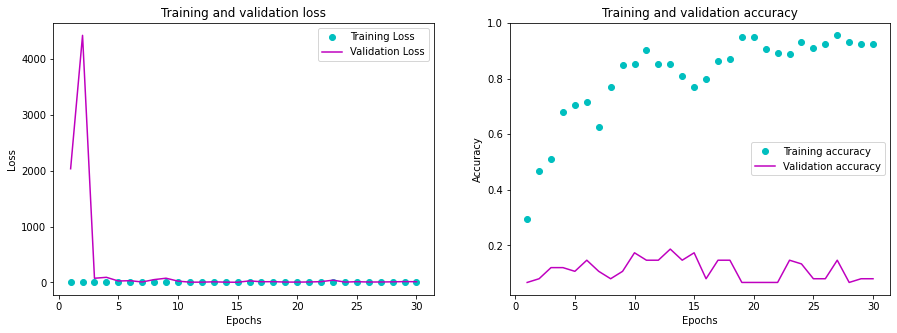

In [44]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [45]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 51ms/step - loss: 10.9365 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [46]:
model.save("model/InceptionV3/fit-adam-InceptionV3-0.001.h5")

# intento 4

In [47]:
baseModel = InceptionV3(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/InceptionV3/base-adam-InceptionV3-0.0001.h5")

In [48]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [49]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 152ms/step - loss: 2.2083 - accuracy: 0.2683 - val_loss: 18.6327 - val_accuracy: 0.1067
Epoch 2/30
23/23 [==============================] - 2s 108ms/step - loss: 0.9858 - accuracy: 0.7020 - val_loss: 28.2387 - val_accuracy: 0.1067
Epoch 3/30
23/23 [==============================] - 2s 109ms/step - loss: 0.4391 - accuracy: 0.8905 - val_loss: 20.6012 - val_accuracy: 0.1067
Epoch 4/30
23/23 [==============================] - 2s 109ms/step - loss: 0.2542 - accuracy: 0.9139 - val_loss: 13.2380 - val_accuracy: 0.1067
Epoch 5/30
23/23 [==============================] - 2s 109ms/step - loss: 0.2338 - accuracy: 0.9550 - val_loss: 9.2669 - val_accuracy: 0.1200
Epoch 6/30
23/23 [==============================] - 2s 109ms/step - loss: 0.1329 - accuracy: 0.9814 - val_loss: 5.4440 - val_accuracy: 0.1200
Epoch 7/30
23/23 [==============================] - 2s 109ms/step - loss: 0.0971 - accuracy: 0.9758 - val_loss: 3.4641 - val_accuracy: 0.1067
Ep

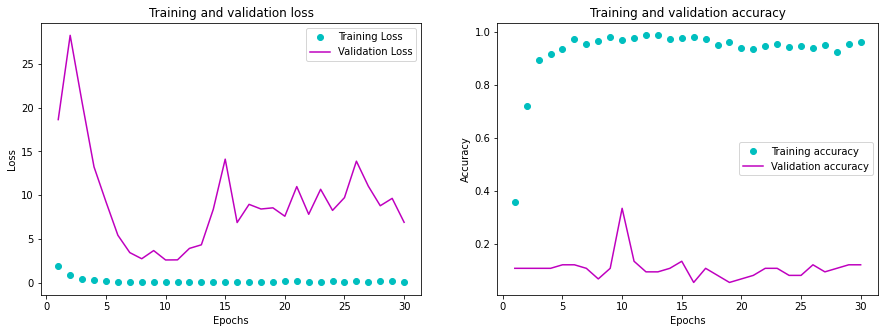

In [50]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [51]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 52ms/step - loss: 6.4703 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [52]:
model.save("model/InceptionV3/fit-adam-InceptionV3-0.0001.h5")

# intento 5

In [53]:
baseModel = InceptionV3(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/InceptionV3/base-adam-InceptionV3-0.00001.h5")

In [54]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [55]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 152ms/step - loss: 2.3445 - accuracy: 0.1601 - val_loss: 9.5493 - val_accuracy: 0.1200
Epoch 2/30
23/23 [==============================] - 2s 108ms/step - loss: 1.9843 - accuracy: 0.3561 - val_loss: 12.7332 - val_accuracy: 0.1200
Epoch 3/30
23/23 [==============================] - 2s 108ms/step - loss: 1.6526 - accuracy: 0.5188 - val_loss: 11.4502 - val_accuracy: 0.1200
Epoch 4/30
23/23 [==============================] - 2s 108ms/step - loss: 1.5056 - accuracy: 0.6112 - val_loss: 10.6964 - val_accuracy: 0.1200
Epoch 5/30
23/23 [==============================] - 2s 108ms/step - loss: 1.2913 - accuracy: 0.7199 - val_loss: 7.4978 - val_accuracy: 0.1200
Epoch 6/30
23/23 [==============================] - 2s 109ms/step - loss: 1.0524 - accuracy: 0.8227 - val_loss: 4.8458 - val_accuracy: 0.1200
Epoch 7/30
23/23 [==============================] - 2s 109ms/step - loss: 1.0242 - accuracy: 0.7688 - val_loss: 3.4930 - val_accuracy: 0.1200
Epo

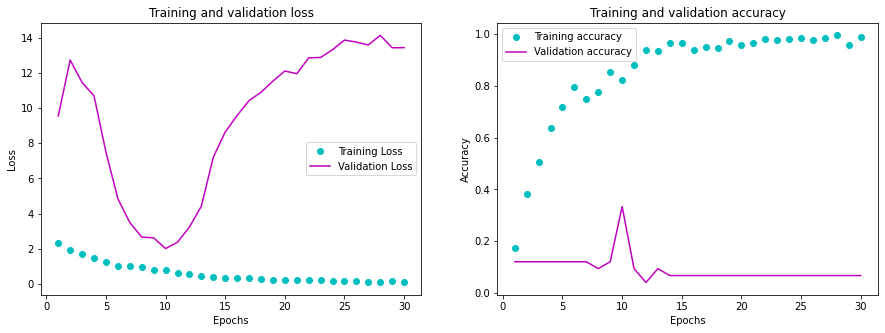

In [56]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [57]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 51ms/step - loss: 11.9900 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [58]:
model.save("model/InceptionV3/fit-adam-InceptionV3-0.00001.h5")

# cambio de SGD

# INTENTO 1

In [59]:
baseModel = InceptionV3(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/InceptionV3/base-SGD-InceptionV3-0.1.h5")

In [60]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [61]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 7s 150ms/step - loss: 4.0762 - accuracy: 0.1785 - val_loss: 66630.4297 - val_accuracy: 0.1067
Epoch 2/30
23/23 [==============================] - 2s 106ms/step - loss: 2.2727 - accuracy: 0.2614 - val_loss: 1344.4547 - val_accuracy: 0.1200
Epoch 3/30
23/23 [==============================] - 2s 105ms/step - loss: 1.8791 - accuracy: 0.3269 - val_loss: 272.3029 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 2s 105ms/step - loss: 1.7266 - accuracy: 0.4879 - val_loss: 212.1242 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 2s 105ms/step - loss: 1.0775 - accuracy: 0.6705 - val_loss: 36.3820 - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 2s 106ms/step - loss: 1.0824 - accuracy: 0.6093 - val_loss: 5.0908 - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 2s 105ms/step - loss: 0.9010 - accuracy: 0.7333 - val_loss: 3.4071 - val_accuracy: 0

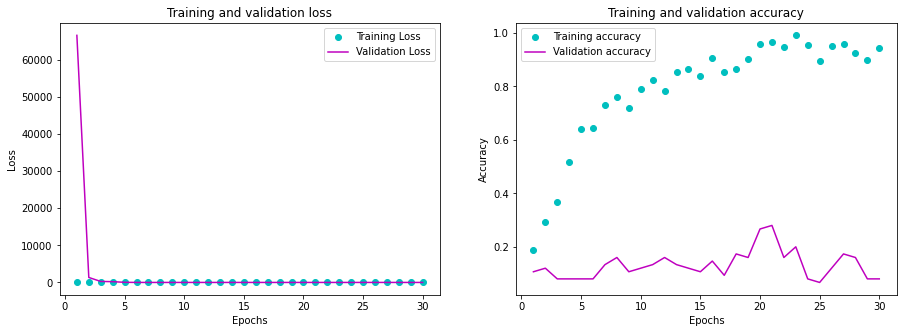

In [62]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [63]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 52ms/step - loss: 3.3136 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 1  0  8  0  0  0  0  0  1  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 1  0  9  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 1  0  9  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [64]:
model.save("model/InceptionV3/fit-SGD-InceptionV3-0.1.h5")

# INTENTO 2

In [65]:
baseModel = InceptionV3(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/InceptionV3/base-SGD-InceptionV3-0.01.h5")

In [66]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [67]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 7s 154ms/step - loss: 2.2105 - accuracy: 0.2400 - val_loss: 4.3449 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 3s 111ms/step - loss: 1.5369 - accuracy: 0.4990 - val_loss: 3.6303 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 2s 106ms/step - loss: 1.1430 - accuracy: 0.6501 - val_loss: 4.3340 - val_accuracy: 0.1067
Epoch 4/30
23/23 [==============================] - 2s 105ms/step - loss: 0.9408 - accuracy: 0.6937 - val_loss: 3.3955 - val_accuracy: 0.0667
Epoch 5/30
23/23 [==============================] - 2s 105ms/step - loss: 0.4342 - accuracy: 0.8807 - val_loss: 2.6794 - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 2s 105ms/step - loss: 0.4990 - accuracy: 0.8515 - val_loss: 3.6265 - val_accuracy: 0.0533
Epoch 7/30
23/23 [==============================] - 2s 105ms/step - loss: 0.3339 - accuracy: 0.9162 - val_loss: 3.4310 - val_accuracy: 0.0667
Epoch 

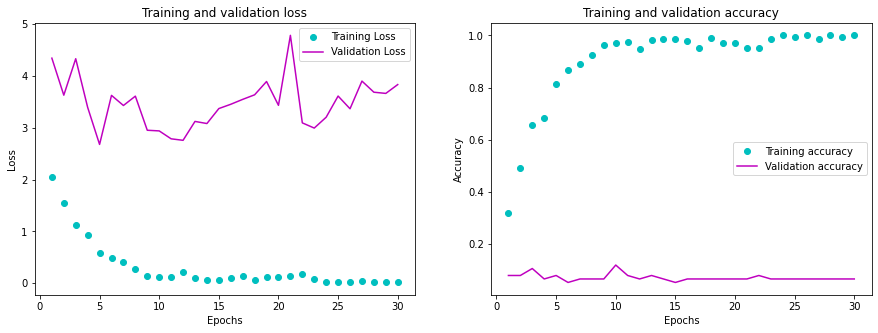

In [68]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [69]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 51ms/step - loss: 3.7627 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [70]:
model.save("model/InceptionV3/fit-SGD-InceptionV3-0.01.h5")

# INTENTO 3

In [71]:
baseModel = InceptionV3(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/InceptionV3/base-SGD-InceptionV3-0.001.h5")

In [72]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [73]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 7s 150ms/step - loss: 2.5236 - accuracy: 0.1483 - val_loss: 8.2608 - val_accuracy: 0.0933
Epoch 2/30
23/23 [==============================] - 2s 105ms/step - loss: 2.1767 - accuracy: 0.2445 - val_loss: 11.5180 - val_accuracy: 0.0933
Epoch 3/30
23/23 [==============================] - 2s 105ms/step - loss: 1.8416 - accuracy: 0.4184 - val_loss: 16.1206 - val_accuracy: 0.1200
Epoch 4/30
23/23 [==============================] - 2s 104ms/step - loss: 1.6323 - accuracy: 0.5273 - val_loss: 20.1623 - val_accuracy: 0.1200
Epoch 5/30
23/23 [==============================] - 2s 106ms/step - loss: 1.4288 - accuracy: 0.6008 - val_loss: 10.0081 - val_accuracy: 0.1200
Epoch 6/30
23/23 [==============================] - 2s 106ms/step - loss: 1.3333 - accuracy: 0.7145 - val_loss: 6.8898 - val_accuracy: 0.1200
Epoch 7/30
23/23 [==============================] - 3s 110ms/step - loss: 1.3160 - accuracy: 0.6926 - val_loss: 3.7398 - val_accuracy: 0.1200
Ep

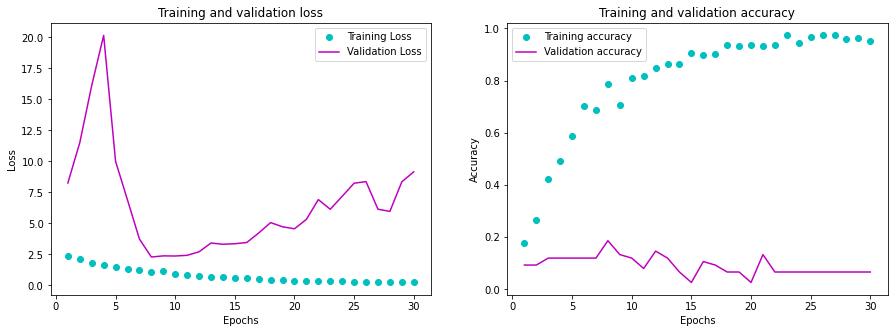

In [74]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [75]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 52ms/step - loss: 7.9269 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [76]:
model.save("model/InceptionV3/fit-SGD-InceptionV3-0.001.h5")

# INTENTO 4

In [77]:
baseModel = InceptionV3(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/InceptionV3/base-SGD-InceptionV3-0.0001.h5")

In [78]:
opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [79]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 158ms/step - loss: 2.5212 - accuracy: 0.0814 - val_loss: 7.1931 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 2s 106ms/step - loss: 2.4504 - accuracy: 0.0773 - val_loss: 9.2537 - val_accuracy: 0.1067
Epoch 3/30
23/23 [==============================] - 2s 106ms/step - loss: 2.4534 - accuracy: 0.1246 - val_loss: 7.2893 - val_accuracy: 0.0933
Epoch 4/30
23/23 [==============================] - 2s 105ms/step - loss: 2.3542 - accuracy: 0.1155 - val_loss: 6.5264 - val_accuracy: 0.0533
Epoch 5/30
23/23 [==============================] - 2s 106ms/step - loss: 2.2594 - accuracy: 0.2034 - val_loss: 6.2719 - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 2s 105ms/step - loss: 2.2356 - accuracy: 0.1879 - val_loss: 5.9691 - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 2s 105ms/step - loss: 2.2111 - accuracy: 0.2195 - val_loss: 4.2521 - val_accuracy: 0.0800
Epoch 

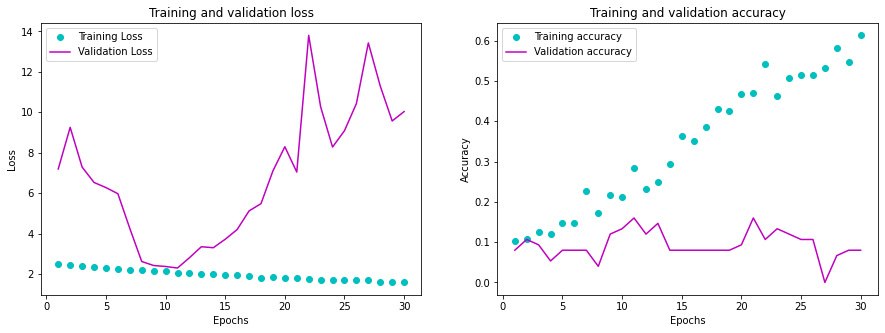

In [80]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [81]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 53ms/step - loss: 7.7087 - accuracy: 0.1200
Confusion_matrix:  tf.Tensor(
[[3 7 0 0 0 0 0 0 0 0]
 [1 9 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 1 0 0 0 0]
 [9 1 0 0 0 0 0 0 0 0]
 [1 9 0 0 0 0 0 0 0 0]
 [9 1 0 0 0 0 0 0 0 0]
 [4 6 0 0 0 0 0 0 0 0]
 [6 3 0 0 0 1 0 0 0 0]
 [9 1 0 0 0 0 0 0 0 0]
 [5 5 0 0 0 0 0 0 0 0]], shape=(10, 10), dtype=int32)


In [82]:
model.save("model/InceptionV3/fit-SGD-InceptionV3-0.0001.h5")

# INTENTO 5

In [83]:
baseModel = InceptionV3(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/InceptionV3/base-SGD-InceptionV3-0.00001.h5")

In [84]:
opt = tf.keras.optimizers.SGD(learning_rate=0.00001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [85]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 149ms/step - loss: 2.4679 - accuracy: 0.1066 - val_loss: 8.3553 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 2s 105ms/step - loss: 2.4772 - accuracy: 0.1276 - val_loss: 5.8739 - val_accuracy: 0.2000
Epoch 3/30
23/23 [==============================] - 2s 105ms/step - loss: 2.5244 - accuracy: 0.0849 - val_loss: 7.8388 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 2s 105ms/step - loss: 2.5169 - accuracy: 0.0808 - val_loss: 6.7107 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 2s 105ms/step - loss: 2.4094 - accuracy: 0.1155 - val_loss: 3.8487 - val_accuracy: 0.0933
Epoch 6/30
23/23 [==============================] - 2s 106ms/step - loss: 2.4489 - accuracy: 0.1186 - val_loss: 4.4501 - val_accuracy: 0.1200
Epoch 7/30
23/23 [==============================] - 2s 105ms/step - loss: 2.4387 - accuracy: 0.1105 - val_loss: 3.4865 - val_accuracy: 0.1067
Epoch 

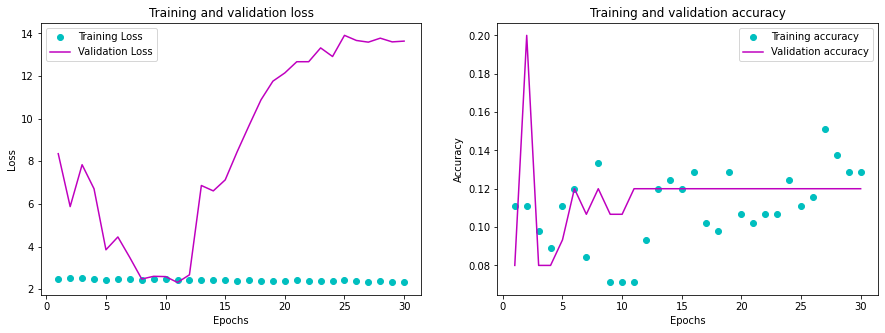

In [86]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [87]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 51ms/step - loss: 13.0512 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]], shape=(10, 10), dtype=int32)


In [88]:
model.save("model/InceptionV3/fit-SGD-InceptionV3-0.00001.h5")

# Cambio a Adamax

# intento 1

In [89]:
baseModel = InceptionV3(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/InceptionV3/base-Adamax-InceptionV3-0.1.h5")

In [90]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.1)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [91]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 153ms/step - loss: 57.3208 - accuracy: 0.0893 - val_loss: 19396400905368193042743296.0000 - val_accuracy: 0.1067
Epoch 2/30
23/23 [==============================] - 2s 108ms/step - loss: 11.3288 - accuracy: 0.1319 - val_loss: 352037612891930624.0000 - val_accuracy: 0.0667
Epoch 3/30
23/23 [==============================] - 2s 108ms/step - loss: 11.3303 - accuracy: 0.1230 - val_loss: 100781969637376.0000 - val_accuracy: 0.0667
Epoch 4/30
23/23 [==============================] - 2s 109ms/step - loss: 5.1772 - accuracy: 0.1198 - val_loss: 181125742592.0000 - val_accuracy: 0.0933
Epoch 5/30
23/23 [==============================] - 2s 108ms/step - loss: 4.0789 - accuracy: 0.1222 - val_loss: 2428438528.0000 - val_accuracy: 0.0933
Epoch 6/30
23/23 [==============================] - 3s 109ms/step - loss: 3.7512 - accuracy: 0.1278 - val_loss: 57380836.0000 - val_accuracy: 0.0933
Epoch 7/30
23/23 [==============================] - 2s 109ms/s

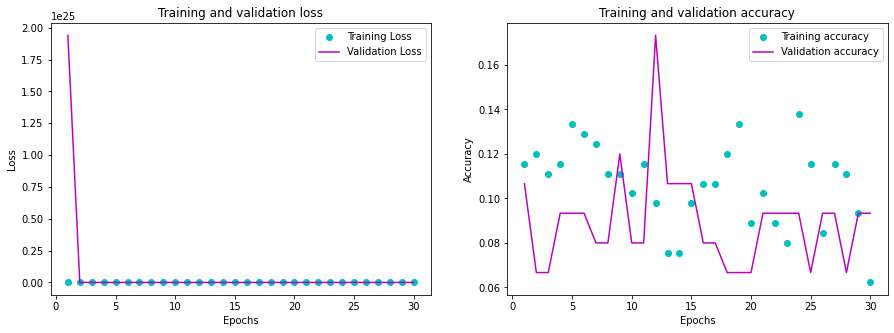

In [92]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [93]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 51ms/step - loss: 492820.8750 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [94]:
model.save("model/InceptionV3/fit-Adamax-InceptionV3-0.1.h5")

# intento 2

In [95]:
baseModel = InceptionV3(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/InceptionV3/base-Adamax-InceptionV3-0.01.h5")

In [96]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.01)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [97]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 154ms/step - loss: 7.2728 - accuracy: 0.0879 - val_loss: 83532947788922880.0000 - val_accuracy: 0.0667
Epoch 2/30
23/23 [==============================] - 3s 110ms/step - loss: 3.1449 - accuracy: 0.1280 - val_loss: 67956506624.0000 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 109ms/step - loss: 2.3344 - accuracy: 0.1249 - val_loss: 248814272.0000 - val_accuracy: 0.0933
Epoch 4/30
23/23 [==============================] - 3s 109ms/step - loss: 2.3315 - accuracy: 0.1202 - val_loss: 3282397.5000 - val_accuracy: 0.1067
Epoch 5/30
23/23 [==============================] - 3s 110ms/step - loss: 2.3370 - accuracy: 0.0979 - val_loss: 4750893.5000 - val_accuracy: 0.0933
Epoch 6/30
23/23 [==============================] - 3s 109ms/step - loss: 2.1863 - accuracy: 0.1646 - val_loss: 92336.2891 - val_accuracy: 0.0933
Epoch 7/30
23/23 [==============================] - 2s 109ms/step - loss: 2.1976 - accuracy: 0.225

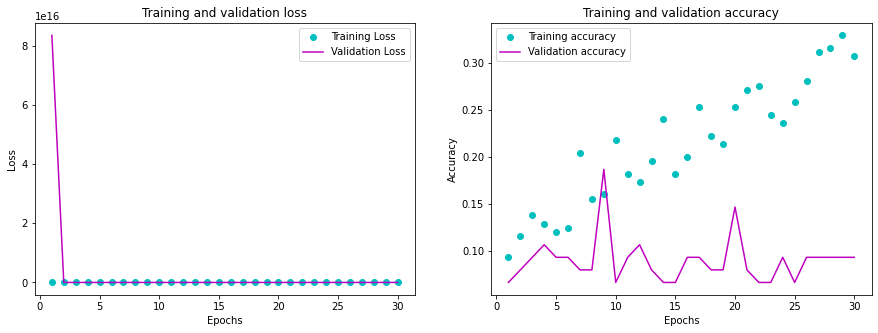

In [98]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [99]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 50ms/step - loss: 222.5958 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]], shape=(10, 10), dtype=int32)


In [100]:
model.save("model/InceptionV3/fit-Adamax-InceptionV3-0.01.h5")

# intento 3

In [101]:
baseModel = InceptionV3(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/InceptionV3/base-Adamax-InceptionV3-0.001.h5")

In [102]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [103]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 155ms/step - loss: 2.8375 - accuracy: 0.3068 - val_loss: 448.5570 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 3s 110ms/step - loss: 1.2401 - accuracy: 0.6255 - val_loss: 66.3602 - val_accuracy: 0.1067
Epoch 3/30
23/23 [==============================] - 3s 110ms/step - loss: 0.8026 - accuracy: 0.7735 - val_loss: 14.7534 - val_accuracy: 0.1067
Epoch 4/30
23/23 [==============================] - 3s 110ms/step - loss: 0.6292 - accuracy: 0.7866 - val_loss: 3.4359 - val_accuracy: 0.0400
Epoch 5/30
23/23 [==============================] - 2s 109ms/step - loss: 0.5178 - accuracy: 0.8732 - val_loss: 3.2888 - val_accuracy: 0.1200
Epoch 6/30
23/23 [==============================] - 3s 110ms/step - loss: 0.3537 - accuracy: 0.8756 - val_loss: 3.1355 - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 3s 110ms/step - loss: 0.3578 - accuracy: 0.8887 - val_loss: 3.0681 - val_accuracy: 0.1067
Ep

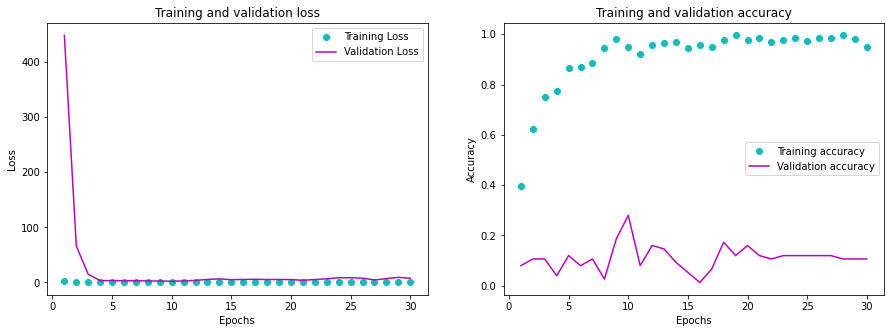

In [104]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [105]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 50ms/step - loss: 6.8418 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]], shape=(10, 10), dtype=int32)


In [106]:
model.save("model/InceptionV3/fit-Adamax-InceptionV3-0.001.h5")

# intento 4

In [107]:
baseModel = InceptionV3(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/InceptionV3/base-Adamax-InceptionV3-0.0001.h5")

In [108]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.0001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [109]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 153ms/step - loss: 2.2366 - accuracy: 0.1998 - val_loss: 9.4725 - val_accuracy: 0.1067
Epoch 2/30
23/23 [==============================] - 2s 109ms/step - loss: 1.1658 - accuracy: 0.6686 - val_loss: 14.6415 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 110ms/step - loss: 0.7790 - accuracy: 0.8205 - val_loss: 12.1089 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 2s 109ms/step - loss: 0.5419 - accuracy: 0.8869 - val_loss: 7.8164 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 2s 109ms/step - loss: 0.4486 - accuracy: 0.9046 - val_loss: 4.9328 - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 2s 109ms/step - loss: 0.2507 - accuracy: 0.9620 - val_loss: 3.6426 - val_accuracy: 0.1333
Epoch 7/30
23/23 [==============================] - 2s 108ms/step - loss: 0.2451 - accuracy: 0.9526 - val_loss: 2.8538 - val_accuracy: 0.0933
Epoc

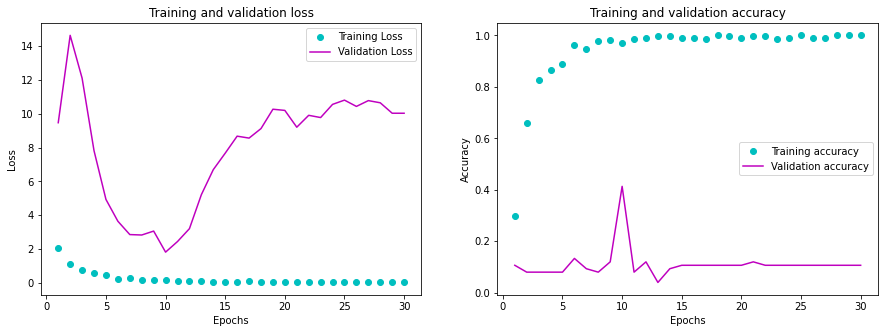

In [110]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [111]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 51ms/step - loss: 10.2351 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]], shape=(10, 10), dtype=int32)


In [112]:
model.save("model/InceptionV3/fit-Adamax-InceptionV3-0.0001.h5")

# intento 5

In [113]:
baseModel = InceptionV3(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("model/InceptionV3/base-Adamax-InceptionV3-0.00001.h5")

In [114]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.00001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [115]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 155ms/step - loss: 2.4344 - accuracy: 0.1161 - val_loss: 6.6026 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 3s 111ms/step - loss: 2.2452 - accuracy: 0.2189 - val_loss: 6.8958 - val_accuracy: 0.1067
Epoch 3/30
23/23 [==============================] - 3s 110ms/step - loss: 2.1456 - accuracy: 0.2463 - val_loss: 8.6906 - val_accuracy: 0.1067
Epoch 4/30
23/23 [==============================] - 3s 110ms/step - loss: 1.9919 - accuracy: 0.3521 - val_loss: 7.7418 - val_accuracy: 0.1067
Epoch 5/30
23/23 [==============================] - 3s 110ms/step - loss: 1.9854 - accuracy: 0.3321 - val_loss: 5.3058 - val_accuracy: 0.1200
Epoch 6/30
23/23 [==============================] - 3s 110ms/step - loss: 1.8277 - accuracy: 0.4510 - val_loss: 4.0060 - val_accuracy: 0.1067
Epoch 7/30
23/23 [==============================] - 3s 110ms/step - loss: 1.7668 - accuracy: 0.5148 - val_loss: 3.4467 - val_accuracy: 0.1067
Epoch 

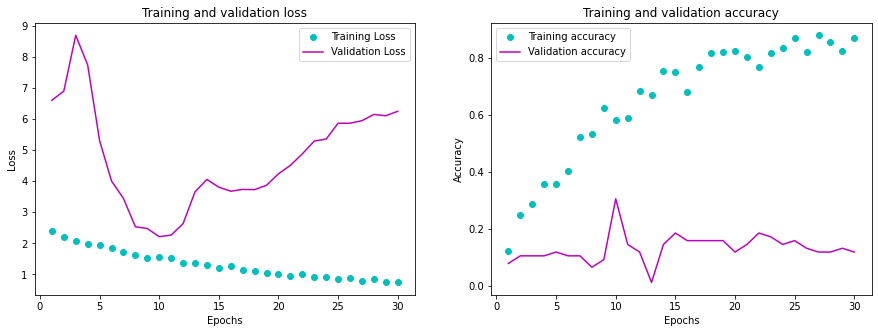

In [116]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [117]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 51ms/step - loss: 5.3355 - accuracy: 0.0900
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0  0  7  0  3  0  0]
 [ 0  0  0  0  0  9  0  1  0  0]
 [ 0  0  1  0  0  9  0  0  0  0]
 [ 0  0  0  0  0  2  0  8  0  0]
 [ 0  0  1  0  0  5  0  4  0  0]
 [ 0  0  0  0  0  2  0  8  0  0]
 [ 0  0  0  0  0  5  0  5  0  0]
 [ 0  0  0  0  0  4  0  6  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  5  0  5  0  0]], shape=(10, 10), dtype=int32)


In [118]:
model.save("model/InceptionV3/fit-Adamax-InceptionV3-0.00001.h5")